<a href="https://colab.research.google.com/github/helenatong/oc_p4_Anticipez_les_besoins_en_consommation_de_batiments/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GradientBoostingRegressor question sur le gradient
pas compris elastic net ... car comment choisir ?
alors que le lasso en prend 1 au hasard
eslascticnetCV useful ?

CE2 Vous avez vérifié qu'il n’y a pas de problème de data leakage (c'est-à-dire, des variables trop corrélées à la variable cible et inconnues a priori dans les données en entrée du modèle). ??

Les principaux algorithmes du machine learning supervisé sont les suivants : forêts aléatoires (plusieurs arbres de décisions), arbres de décision, algorithme K-NN (k-Nearest Neighbors) (qui se ressemble.. est identique), régression linéaire, algorithme de Naïve Bayes??, machine à vecteurs de support (SVM)??, régression logistique (hum ?) et boosting de gradient (minimisation de la fonction de coût)

que faire quand on a un overfit ?
on diminue le score du train pour éviter que le delta soit trop grand? maybe

# **Introduction**

---

## **Prérequis**
- Télécharger [dataset nettoyé](https://drive.google.com/file/d/1-EuzI1ibLAG_1brg_v3MKcDtEgKDFIdl/view?usp=drive_link) dans Google Drive
- Modifier le chemin du fichier dans le code


---

## **Prédiction de la première variable cible: Emission de carbone**

---


## **Sommaire:**

### **I. Installation et mise en place de l'environnement de travail**

### **II. Définitions des fonctions auxiliaires**

### **III. Prédiction de la variable TotalGHGEmissions**
**A. Entrainement du premier modèle: régression linéaire**

# **I. Installation et mise en place de l'environnement de travail**

In [232]:
# installation des librairies
!pip install shap

In [233]:
# importation des librairies
import numpy as np
import pandas as pd

import zipfile
import os

import re

import sys

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import shap

import datetime

from google.colab import drive

In [234]:
# informations sur l'environnement virtuel
print('Version des librairies :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Matplotlib    : ' + mpl.__version__)

now  = datetime.datetime.now().isoformat()
print('Run date      : ' + now)

Version des librairies :
Python        : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy         : 1.25.2
Pandas        : 2.0.3
Matplotlib    : 3.7.1
Run date      : 2024-06-04T18:22:52.787633


In [235]:
# configurations de l'affichages des données
pd.set_option('display.max_columns', None)

In [236]:
# connexion au drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [237]:
# vérification de l'importation
df = pd.read_parquet('/content/drive/MyDrive/openclassrooms/project_list/project_4/data/cleaned_2016_Building_Energy_Benchmarking.pq')
print (df.shape)
df.head(2)

(1476, 15)


,OSEBuildingID,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,NbBuildingUsages,BuildingAge,NbYearENERGYSTARCertified,RatioSteamUse,RatioElectricity
0,1,DOWNTOWN,1.0,12,88434,0,Hotel,60.0,7226362.5,249.98,1,89,0,0.28,0.55
1,2,DOWNTOWN,1.0,11,103566,15064,Hotel,61.0,8387933.0,295.86,3,20,0,0.00,0.39


In [238]:
# vérification des données
df.isna().sum(axis=0)

OSEBuildingID                0
Neighborhood                 0
NumberofBuildings            0
NumberofFloors               0
PropertyGFATotal             0
PropertyGFAParking           0
LargestPropertyUseType       0
ENERGYSTARScore              0
SiteEnergyUse(kBtu)          0
TotalGHGEmissions            0
NbBuildingUsages             0
BuildingAge                  0
NbYearENERGYSTARCertified    0
RatioSteamUse                0
RatioElectricity             0
dtype: int64

# **II. Feature engineering**

**Suppression des modalités représentant moins de 5% du dataset**

In [239]:
# Obtenir le nombre d'occurrences de chaque modalité: Neighborhood
modalities_counts = df['Neighborhood'].value_counts()
print("Nombre d'occurrences de chaque modalité :")
print(modalities_counts)
print(modalities_counts/df.shape[0])

Nombre d'occurrences de chaque modalité :
Neighborhood
DOWNTOWN                 338
GREATER DUWAMISH         319
LAKE UNION               139
MAGNOLIA / QUEEN ANNE    137
EAST                     110
NORTHEAST                 99
NORTHWEST                 74
BALLARD                   62
NORTH                     57
CENTRAL                   42
DELRIDGE                  38
SOUTHWEST                 31
SOUTHEAST                 30
Name: count, dtype: int64
Neighborhood
DOWNTOWN                 0.228997
GREATER DUWAMISH         0.216125
LAKE UNION               0.094173
MAGNOLIA / QUEEN ANNE    0.092818
EAST                     0.074526
NORTHEAST                0.067073
NORTHWEST                0.050136
BALLARD                  0.042005
NORTH                    0.038618
CENTRAL                  0.028455
DELRIDGE                 0.025745
SOUTHWEST                0.021003
SOUTHEAST                0.020325
Name: count, dtype: float64


In [240]:
# Seuil de 5%
threshold = 0.05 * df.shape[0]

# Transformer en 'OTHER' pour les valeurs représentant moins de 5%
df['Neighborhood'] = df['Neighborhood'].apply(lambda x: x if modalities_counts[x] > threshold else 'OTHER')

In [241]:
# Obtenir le nombre d'occurrences de chaque modalité: LargestPropertyUseType
modalities_counts = df['LargestPropertyUseType'].value_counts()
print("Nombre d'occurrences de chaque modalité :")
print(modalities_counts)
print(modalities_counts/df.shape[0])

Nombre d'occurrences de chaque modalité :
LargestPropertyUseType
Office                                                  484
Non-Refrigerated Warehouse                              197
Retail Store                                             91
Other                                                    88
Hotel                                                    76
Worship Facility                                         69
Distribution Center                                      54
Supermarket/Grocery Store                                41
Medical Office                                           41
K-12 School                                              38
Other - Recreation                                       31
Parking                                                  29
Self-Storage Facility                                    28
Other - Entertainment/Public Assembly                    21
Senior Care Community                                    20
College/University                 

In [242]:
# Transformer en 'Other' pour les valeurs représentant moins de 5%
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].apply(lambda x: x if modalities_counts[x] > threshold else 'Other')

**Suppression des variables peu pertinentes pour notre modèle**

In [243]:
#pas nécessaire pour l'entrainement des modèles
df.drop(columns=['OSEBuildingID'], inplace=True)

# **III. Définitions des variables globales**

In [244]:
TARGET = 'TotalGHGEmissions'
NUM_FEATURES = ['NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'ENERGYSTARScore', 'NbBuildingUsages',
       'BuildingAge', 'NbYearENERGYSTARCertified', 'RatioSteamUse',
       'RatioElectricity', 'PropertyGFAParking']

CAT_FEATURES = [f for f in df.columns if f not in NUM_FEATURES and f != TARGET and f != 'SiteEnergyUse(kBtu)']
print(CAT_FEATURES)

['Neighborhood', 'LargestPropertyUseType']


In [245]:
df1 = df.copy()

# **IV. Entrainement des modèles**

##**A. Entrainement d'un modèle linéaire: LinearRegression**

In [246]:
# séparation des variables explicatives de la variable à prédire
df1 = df.copy()
y = df1.pop(TARGET)
X = df1

In [247]:
# features engineering
y = np.log(y + 1)

preprocessor = ColumnTransformer(
    transformers=[
        ('encoder_nominal', OneHotEncoder(handle_unknown='ignore',sparse_output=False), CAT_FEATURES),
         ('norma', PowerTransformer(), NUM_FEATURES)
    ],
    remainder='drop'
  )

In [248]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
  ])

In [249]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__fit_intercept' : [False, True]
    }

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2') #1476*0.80/5 = 236 données par pli pour cv=5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_LR = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}') #moyenne des scores sur la validation croisée
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_LR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_LR.score(X_test, y_test).round(3)}')
print(f'diff = {(best_model_LR.score(X_test, y_test)-best_model_LR.score(X_train, y_train)).round(3)}')
mean_time_LR = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs hyperparamètres: {'regressor__fit_intercept': True}
Moyenne des scores: 0.736
----------------
Score sur le train : 0.748
Score sur le test : 0.774
diff = 0.026


In [250]:
# détails de la validation croisée
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.085197,0.011490,0.013076,0.001728,False,{'regressor__fit_intercept': False},0.67823,0.759245,0.73076,0.769897,0.739698,0.735566,0.031834,2
1,0.077322,0.002562,0.011747,0.002394,True,{'regressor__fit_intercept': True},0.67823,0.759245,0.73076,0.770035,0.740213,0.735697,0.031877,1


##**B. Entrainement d'un modèle linéaire: RandomForestRegressor**

In [266]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
  ])

In [269]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)
# limitation de la complexité pour éviter l'overfitting

param_grid = {
    'regressor__max_depth'     : [3, 4, 5],
    'regressor__criterion'     : ['squared_error', 'absolute_error'],
    'regressor__min_samples_split' : [2, 5, 7, 9]
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_RFR = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_RFR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_RFR.score(X_test, y_test).round(3)}')
print(f'diff = {(best_model_RFR.score(X_test, y_test)-best_model_RFR.score(X_train, y_train)).round(3)}')
mean_time_RFR = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs hyperparamètres: {'regressor__criterion': 'absolute_error', 'regressor__max_depth': 5, 'regressor__min_samples_split': 2}
Moyenne des scores: 0.722
----------------
Score sur le train : 0.781
Score sur le test : 0.745
diff = -0.035


In [253]:
# détails de la validation croisée
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__criterion,param_regressor__max_depth,param_regressor__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.413907,0.019016,0.019534,0.002747,squared_error,2,2,"{'regressor__criterion': 'squared_error', 'reg...",0.520086,0.543405,0.627442,0.602578,0.588619,0.576426,0.039242,25
1,0.394300,0.008401,0.017548,0.000921,squared_error,2,5,"{'regressor__criterion': 'squared_error', 'reg...",0.518125,0.545554,0.625072,0.603599,0.583722,0.575214,0.038737,26
2,0.390363,0.008107,0.019257,0.002696,squared_error,2,7,"{'regressor__criterion': 'squared_error', 'reg...",0.516471,0.547253,0.620304,0.600048,0.589254,0.574666,0.037624,27
3,0.397870,0.011762,0.018411,0.001690,squared_error,2,9,"{'regressor__criterion': 'squared_error', 'reg...",0.513907,0.545673,0.630077,0.594397,0.585882,0.573987,0.040288,28
4,0.828017,0.136209,0.040732,0.005897,squared_error,3,2,"{'regressor__criterion': 'squared_error', 'reg...",0.600016,0.637733,0.691720,0.692700,0.680668,0.660568,0.036318,17
5,0.818229,0.087636,0.025287,0.008467,squared_error,3,5,"{'regressor__criterion': 'squared_error', 'reg...",0.599640,0.642984,0.695630,0.681597,0.678048,0.659580,0.034623,18
6,0.801416,0.088264,0.037601,0.004529,squared_error,3,7,"{'regressor__criterion': 'squared_error', 'reg...",0.595974,0.638850,0.690392,0.690381,0.677811,0.658681,0.036611,20
7,0.687573,0.199102,0.031550,0.011208,squared_error,3,9,"{'regressor__criterion': 'squared_error', 'reg...",0.592178,0.642382,0.695885,0.678315,0.679339,0.657620,0.037092,23
8,0.508121,0.032855,0.020449,0.002023,squared_error,4,2,"{'regressor__criterion': 'squared_error', 'reg...",0.635722,0.675616,0.728168,0.724331,0.726854,0.698138,0.036920,12
9,0.500368,0.011815,0.026629,0.008788,squared_error,4,5,"{'regressor__criterion': 'squared_error', 'reg...",0.638024,0.674176,0.734101,0.721682,0.728177,0.699232,0.037234,10


##**C. Entrainement d'un modèle linéaire: GradientBoostingRegressor**

In [254]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
  ])

In [255]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)
# limitation des paramètres pour éviter l'overfitting

param_grid = {
    'regressor__learning_rate'      : [0.10, 0.001, 0.05, 0.20],
    'regressor__max_depth'          : [1],
    'regressor__subsample'          : [0.8, 0.9],
    'regressor__max_features'       : ['sqrt', 'log2'],
    'regressor__loss'               : ['squared_error', 'absolute_error']
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_GBR = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_GBR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_GBR.score(X_test, y_test).round(3)}')
print(f'diff = {(best_model_GBR.score(X_test, y_test)-best_model_GBR.score(X_train, y_train)).round(3)}')
mean_time_GBR = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Meilleurs hyperparamètres: {'regressor__learning_rate': 0.2, 'regressor__loss': 'squared_error', 'regressor__max_depth': 1, 'regressor__max_features': 'sqrt', 'regressor__subsample': 0.9}
Moyenne des scores: 0.724
----------------
Score sur le train : 0.764
Score sur le test : 0.727
diff = -0.037


In [256]:
# détails de la validation croisée
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__learning_rate,param_regressor__loss,param_regressor__max_depth,param_regressor__max_features,param_regressor__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.338216,0.035296,0.024697,0.013139,0.1,squared_error,1,sqrt,0.8,"{'regressor__learning_rate': 0.1, 'regressor__...",0.584450,0.658023,0.691245,0.709628,0.684613,0.665592,0.043819,9
1,0.365150,0.012435,0.028920,0.004200,0.1,squared_error,1,sqrt,0.9,"{'regressor__learning_rate': 0.1, 'regressor__...",0.556046,0.656003,0.705856,0.665054,0.691495,0.654891,0.052559,12
2,0.364397,0.017173,0.027606,0.006099,0.1,squared_error,1,log2,0.8,"{'regressor__learning_rate': 0.1, 'regressor__...",0.565573,0.663026,0.677965,0.679406,0.698019,0.656798,0.046945,11
3,0.251913,0.064223,0.014497,0.003837,0.1,squared_error,1,log2,0.9,"{'regressor__learning_rate': 0.1, 'regressor__...",0.572284,0.646534,0.708859,0.699419,0.677134,0.660846,0.049207,10
4,0.299852,0.006350,0.010989,0.000307,0.1,absolute_error,1,sqrt,0.8,"{'regressor__learning_rate': 0.1, 'regressor__...",0.545101,0.628903,0.671246,0.681073,0.645544,0.634373,0.048300,14
5,0.299928,0.008687,0.013357,0.001757,0.1,absolute_error,1,sqrt,0.9,"{'regressor__learning_rate': 0.1, 'regressor__...",0.575870,0.614845,0.620702,0.649753,0.642658,0.620765,0.025962,16
6,0.325718,0.015681,0.013362,0.000958,0.1,absolute_error,1,log2,0.8,"{'regressor__learning_rate': 0.1, 'regressor__...",0.560867,0.648665,0.647555,0.694070,0.638844,0.638000,0.043126,13
7,0.326763,0.017442,0.013387,0.001096,0.1,absolute_error,1,log2,0.9,"{'regressor__learning_rate': 0.1, 'regressor__...",0.570261,0.615832,0.662635,0.633985,0.680268,0.632596,0.038324,15
8,0.187875,0.007938,0.015797,0.006850,0.001,squared_error,1,sqrt,0.8,"{'regressor__learning_rate': 0.001, 'regressor...",0.017326,0.021847,0.007691,0.023946,0.023313,0.018825,0.006028,25
9,0.191421,0.017960,0.012176,0.000399,0.001,squared_error,1,sqrt,0.9,"{'regressor__learning_rate': 0.001, 'regressor...",0.014077,0.020204,0.006367,0.023308,0.027012,0.018194,0.007277,28


##**D. Entrainement d'un modèle linéaire: SVR**

In [257]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
  ])

In [258]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__kernel'          : ['rbf', 'poly', 'linear', 'sigmoid'], #passer dans les dimensions supérieures
    'regressor__degree'          : [3, 2, 4], #for poly
    'regressor__gamma'           : ['scale', 'auto'], #for rbf, poly and sigmoid
    'regressor__tol'             : [1e-3]
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_SVR = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_SVR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_SVR.score(X_test, y_test).round(3)}')
print(f'diff = {(best_model_SVR.score(X_test, y_test)-best_model_SVR.score(X_train, y_train)).round(3)}')
mean_time_SVR = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs hyperparamètres: {'regressor__degree': 3, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear', 'regressor__tol': 0.001}
Moyenne des scores: 0.738
----------------
Score sur le train : 0.745
Score sur le test : 0.773
diff = 0.028


In [259]:
# détails de la validation croisée
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__degree,param_regressor__gamma,param_regressor__kernel,param_regressor__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.208682,0.017026,0.035688,0.001452,3,scale,rbf,0.001,"{'regressor__degree': 3, 'regressor__gamma': '...",0.634370,0.736205,0.741789,0.768376,0.681525,0.712453,0.048178,12
1,0.216793,0.021112,0.026265,0.006684,3,scale,poly,0.001,"{'regressor__degree': 3, 'regressor__gamma': '...",0.645872,0.727212,0.730860,0.729838,0.753628,0.717482,0.037043,11
2,0.333040,0.027158,0.022635,0.000940,3,scale,linear,0.001,"{'regressor__degree': 3, 'regressor__gamma': '...",0.685685,0.753124,0.729297,0.775649,0.746161,0.737983,0.030084,1
3,0.225080,0.009300,0.035299,0.000751,3,scale,sigmoid,0.001,"{'regressor__degree': 3, 'regressor__gamma': '...",-10.355405,-7.922320,-16.386324,-13.573609,-12.623862,-12.172304,2.873639,22
4,0.183976,0.009806,0.037810,0.002054,3,auto,rbf,0.001,"{'regressor__degree': 3, 'regressor__gamma': '...",0.663567,0.752593,0.761015,0.781576,0.718798,0.735510,0.041278,8
5,0.180513,0.004820,0.030116,0.007509,3,auto,poly,0.001,"{'regressor__degree': 3, 'regressor__gamma': '...",0.549239,0.610891,0.652369,0.607082,0.663054,0.616527,0.040244,16
6,0.404894,0.065312,0.030951,0.009208,3,auto,linear,0.001,"{'regressor__degree': 3, 'regressor__gamma': '...",0.685685,0.753124,0.729297,0.775649,0.746161,0.737983,0.030084,1
7,0.357228,0.034073,0.055974,0.017525,3,auto,sigmoid,0.001,"{'regressor__degree': 3, 'regressor__gamma': '...",0.236292,0.442827,0.144117,0.218629,0.160887,0.240550,0.106827,19
8,0.290416,0.025598,0.054838,0.017510,2,scale,rbf,0.001,"{'regressor__degree': 2, 'regressor__gamma': '...",0.634370,0.736205,0.741789,0.768376,0.681525,0.712453,0.048178,12
9,0.313663,0.039779,0.035576,0.008015,2,scale,poly,0.001,"{'regressor__degree': 2, 'regressor__gamma': '...",0.647151,0.734262,0.779849,0.759100,0.762319,0.736536,0.047000,7


##**E. Entrainement d'un modèle linéaire: ElasticNet**

In [260]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
  ])

In [261]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__alpha'          : [1, 0.05, 0.1, 0.5, 1.5],
    'regressor__l1_ratio'       : [0.5, 0.10, 0.20, 0.75],
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_EN = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_EN.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_EN.score(X_test, y_test).round(3)}')
print(f'diff = {(best_model_EN.score(X_test, y_test)-best_model_EN.score(X_train, y_train)).round(3)}')
mean_time_EN = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs hyperparamètres: {'regressor__alpha': 0.05, 'regressor__l1_ratio': 0.1}
Moyenne des scores: 0.733
----------------
Score sur le train : 0.741
Score sur le test : 0.766
diff = 0.025


In [262]:
# détails de la validation croisée
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,param_regressor__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.073057,0.004454,0.014751,0.005877,1,0.5,"{'regressor__alpha': 1, 'regressor__l1_ratio':...",0.215981,0.232538,0.238848,0.261311,0.229070,0.235549,0.014890,17
1,0.076416,0.008198,0.012309,0.002205,1,0.1,"{'regressor__alpha': 1, 'regressor__l1_ratio':...",0.404736,0.478522,0.491062,0.492039,0.469452,0.467162,0.032315,12
2,0.080312,0.003105,0.013445,0.003251,1,0.2,"{'regressor__alpha': 1, 'regressor__l1_ratio':...",0.369081,0.419341,0.426696,0.437868,0.406309,0.411859,0.023721,14
3,0.084668,0.013489,0.013420,0.002647,1,0.75,"{'regressor__alpha': 1, 'regressor__l1_ratio':...",0.038684,0.038046,0.030859,0.051558,0.033771,0.038584,0.007092,18
4,0.070310,0.002738,0.011210,0.000573,0.05,0.5,"{'regressor__alpha': 0.05, 'regressor__l1_rati...",0.666080,0.748781,0.727794,0.759906,0.733510,0.727214,0.032592,3
5,0.072518,0.004441,0.012045,0.001496,0.05,0.1,"{'regressor__alpha': 0.05, 'regressor__l1_rati...",0.669402,0.754158,0.735600,0.763662,0.740872,0.732739,0.033169,1
6,0.079743,0.011264,0.011108,0.000866,0.05,0.2,"{'regressor__alpha': 0.05, 'regressor__l1_rati...",0.668447,0.751811,0.733718,0.762709,0.739579,0.731253,0.032961,2
7,0.077404,0.002983,0.012440,0.001827,0.05,0.75,"{'regressor__alpha': 0.05, 'regressor__l1_rati...",0.663386,0.743546,0.720809,0.756081,0.728183,0.722401,0.031938,4
8,0.073165,0.001625,0.010589,0.000299,0.1,0.5,"{'regressor__alpha': 0.1, 'regressor__l1_ratio...",0.643684,0.724088,0.709282,0.737369,0.709975,0.704880,0.032295,7
9,0.076883,0.006122,0.010594,0.000202,0.1,0.1,"{'regressor__alpha': 0.1, 'regressor__l1_ratio...",0.655066,0.744026,0.730169,0.750798,0.730401,0.722092,0.034444,5


## Choix de l'algorithme:

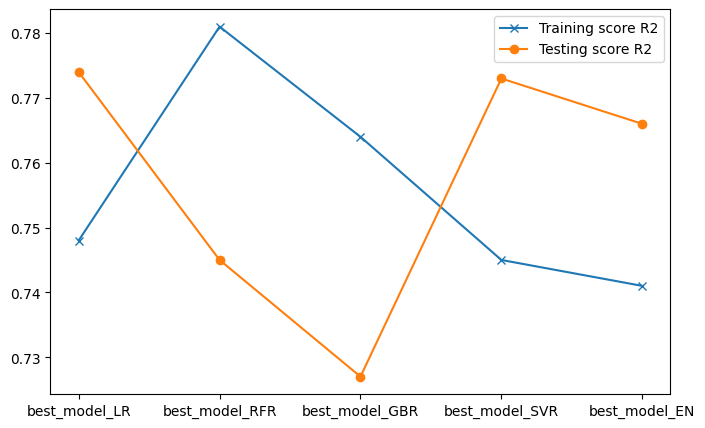

In [272]:
# visualisation des scores des différents modèles
plt.figure(figsize=(8,5))

models        = ['best_model_LR', 'best_model_RFR', 'best_model_GBR', 'best_model_SVR', 'best_model_EN']
train_score  = [best_model_LR.score(X_train, y_train).round(3), best_model_RFR.score(X_train, y_train).round(3), best_model_GBR.score(X_train, y_train).round(3), best_model_SVR.score(X_train, y_train).round(3), best_model_EN.score(X_train, y_train).round(3)]
test_score    = [best_model_LR.score(X_test, y_test).round(3), best_model_RFR.score(X_test, y_test).round(3), best_model_GBR.score(X_test, y_test).round(3), best_model_SVR.score(X_test, y_test).round(3), best_model_EN.score(X_test, y_test).round(3)]

plt.plot(models, train_score, label='Training score R2', marker='x')
plt.plot(models, test_score, label='Testing score R2', marker='o')

plt.legend()
plt.show()

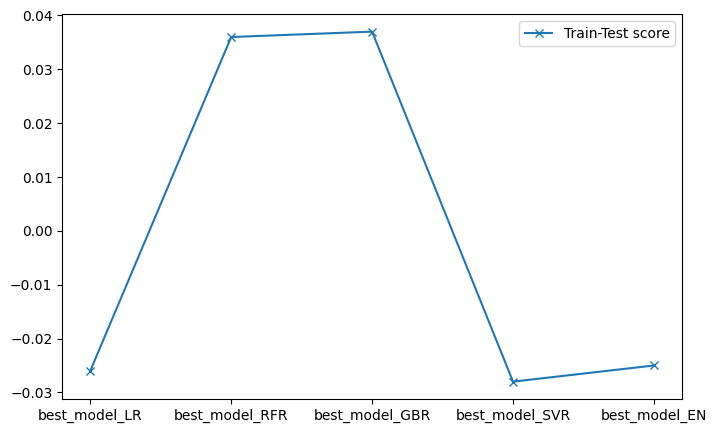

In [274]:
# visualisation des différences de scores des différents modèles
plt.figure(figsize=(8,5))

models        = ['best_model_LR', 'best_model_RFR', 'best_model_GBR', 'best_model_SVR', 'best_model_EN']
diff_score = [a - b for a, b in zip(train_score, test_score)]

plt.plot(models, diff_score, label='Train-Test score', marker='x')

plt.legend()
plt.show()

Les 2 meilleurs modèles sont le RandomForestRegressor et le GradientBoostingRegressor: Le score atteint quasiment 1 et il n'y a pas de problème d'overfitting.

Pour choisir le modèle, je vais m'intéresser au temps d'entrainement.

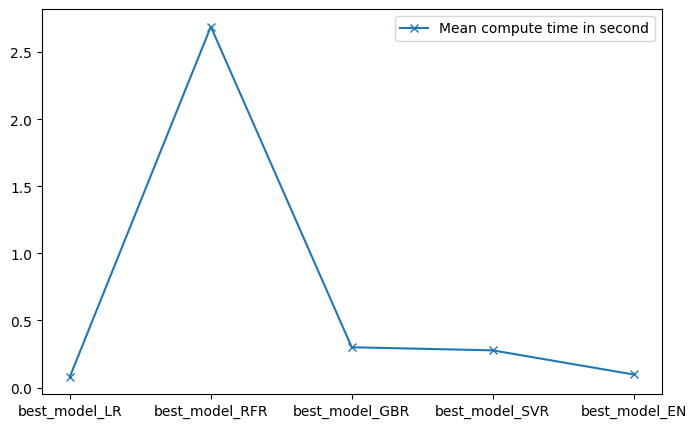

In [264]:
# visualisation du temps de computage
plt.figure(figsize=(8,5))
mean_process_time = [mean_time_LR, mean_time_RFR, mean_time_GBR, mean_time_SVR, mean_time_EN]
plt.plot(models, mean_process_time, label='Mean compute time in second', marker='x')

plt.legend()
plt.show()

Le modèle RandomForestRegressor prend en moyenne 7 fois plus de temps à entrainer que le modèle GradientBoostingRegressor.

Pour notre jeu de données, cette différence est insignifiante. Il n'y a que 1476 observations.

Néanmoins, si le jeu de données comporte davantage de données, cela pourra augmenter considérablement le temps de calcul.
Pour ces raisons, je vais choisir GradientBoostingRegressor comme modèle final.

In [265]:
best_model_pipeline = best_model_GBR
best_model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder_nominal',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Neighborhood',
                                                   'LargestPropertyUseType']),
                                                 ('norma', PowerTransformer(),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'ENERGYSTARScore',
                                                   'NbBuildingUsages',
                                                   'BuildingAge',
                                                   'NbYearENERGYSTARCertified',
                                                   'RatioSteamUse',
                                                   'RatioElectricity',
                                                   'PropertyGFAParking'])])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.2, max_depth=1,
                                           max_features='sqrt',
                                           subsample=0.9))])

In [231]:
best_model = best_model_pipeline[1]
print('hyperparameters of GradientBoostingRegressor:')
best_model.get_params()

hyperparameters of GradientBoostingRegressor:


{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.2,
 'loss': 'squared_error',
 'max_depth': 1,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 0.8,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

# **V. Analyse des variables explicatives du modèle: SHAP**

In [156]:
df_model = df.copy()
y = df_model.pop(TARGET)
X = df_model

y_transformed = np.log(y + 1)
X_transformed = preprocessor.fit_transform(X)

explainer = shap.Explainer(best_model) #créer un objet à partir de best_model
shap_values = explainer(X_transformed) #equivalent de fit
np.shape(shap_values.values)

(1476, 23)

In [157]:
# voir la contribution globale
ohe_feature_names = preprocessor.named_transformers_['encoder_nominal'].get_feature_names_out(CAT_FEATURES)
final_feature_names = np.concatenate([ohe_feature_names, NUM_FEATURES])

shap.initjs()
shap.force_plot(shap_values, feature_names=final_feature_names, out_names='Emission de carbone')

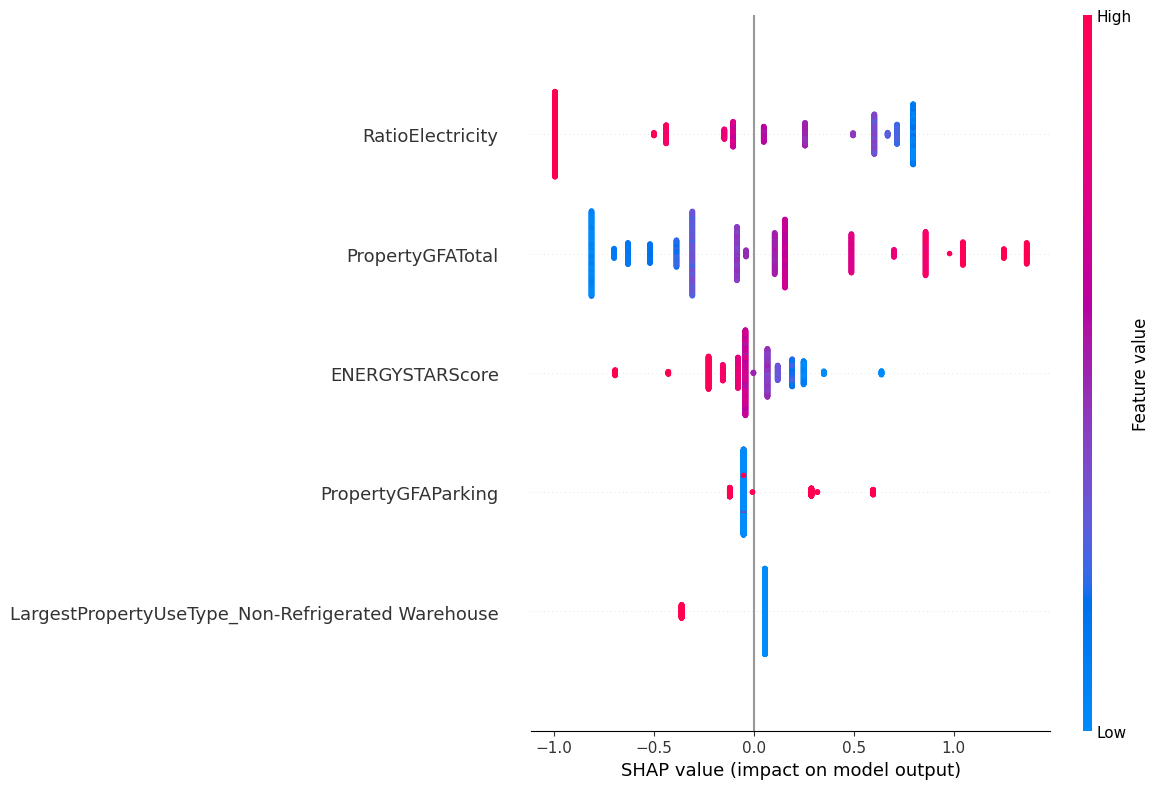

In [158]:
# Poids de chaque variable
shap.summary_plot(shap_values, plot_type='dot', feature_names=final_feature_names, max_display=5, color='red', plot_size=(12,8), show_values_in_legend=True)

Parmi le top 5 des variables qui influencent la prédiction de notre variable cible, seule la variable SteamUse influence uniquement positivement la prédiction.

Les amplitudes d'impact vont de -2 à +3 kBtu pour une référence située à 4.017.

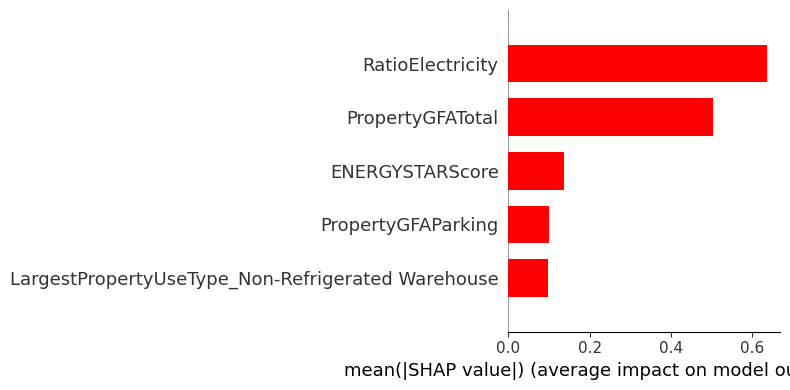

In [159]:
# Poids de chaque variable
shap.summary_plot(shap_values, plot_type='bar', feature_names=final_feature_names, max_display=5, color='red', plot_size=(8,4), show_values_in_legend=True)

Dans le beeswarm, chaque point représente un individu. On voit la distribution des valeurs SHAP.

In [160]:
# encoded_column_index = np.where(final_feature_names == 'LastYearENERGYSTARCertified')[0][0]

# star_certification = [
#     "StarCertifiedOnce" if int(shap_values[i, encoded_column_index].data) == 0 else "NotStarCertified"
#     for i in range(shap_values.shape[0])
# ]

# # Créer un objet Explanation avec les cohortes
# shap_cohorts = shap_values.cohorts(star_certification)

# # Tracer les moyennes des valeurs SHAP pour chaque cohorte
# shap.plots.bar(shap_cohorts.abs.mean(0), max_display=5)

# **VI. Vérifier l'effet de la variable STAR** AVEC LES MM PARAM ?

Préparation des données

In [161]:
NUM_FEATURES = ['NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'NbBuildingUsages',
       'BuildingAge', 'NbYearENERGYSTARCertified', 'RatioSteamUse',
       'RatioElectricity', 'RatioNaturalGas']

CAT_FEATURES = [f for f in df.columns if f not in NUM_FEATURES and f != TARGET and f != 'SiteEnergyUse(kBtu)' and f != 'ENERGYSTARScore']
print(CAT_FEATURES)

['Neighborhood', 'PropertyGFAParking', 'LargestPropertyUseType']


In [162]:
df2 = df.copy()
df2.drop(columns=['ENERGYSTARScore'], inplace=True)

In [163]:
# features engineering
y = df2.pop(TARGET)
X = df2

y = np.log(y + 1)

preprocessor = ColumnTransformer(
    transformers=[
        ('encoder_nominal', OneHotEncoder(handle_unknown='ignore',sparse_output=False), CAT_FEATURES),
         ('norma', PowerTransformer(), NUM_FEATURES)
    ],
    remainder='drop'
  )

In [164]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
  ])

In [165]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__n_estimators'  : [100, 500]#,
    # 'regressor__max_depth'     : [2, 3, 4, 5],
    # 'regressor__criterion'     : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    # 'regressor__min_samples_split' : [2, 10, 100]
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model = gs.best_estimator_

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {gs.best_score_.round(3)}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model.score(X_test, y_test).round(3)}')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 147, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 176, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'RatioNaturalGas'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/__init__.py", line 448, in _get_column_indices
    col_idx = all_columns.get_loc(col)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3655, in get_loc
    raise KeyError(key) from err
KeyError: 'RatioNaturalGas'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py", line 724, in fit_transform
    self._validate_column_callables(X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py", line 426, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/__init__.py", line 456, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


La variable ENERGYSTARScore n'est pas nécessaire à l'entrainement du modèle car elle n'apporte pas d'amélioration de la précision des prédictions du modèle.

Le modèle le plus précis et robuste est le xxx.
